## Deep Convolutional Generative Adversarial Networks Trained on Fashion MNIST

In [1]:
# import all required packages
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

from keras.preprocessing.image import ImageDataGenerator

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

Using TensorFlow backend.


In [2]:
dataset_path = '/home/iwona/Data/tagging/gan_category/train'
BUFFER_SIZE = 60000
BATCH_SIZE = 256
HEIGHT = 28
WIDTH = 28

test = '/home/iwona/Data/tagging/gan_category/eval/2877/ec2c2a6d59bc0e7ce5eb8e292b3c4e10c8360971.jpg'

In [3]:
list_ds = tf.data.Dataset.list_files(str(dataset_path+'/*/dd*'))

In [4]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

In [5]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [6]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] 

### Load and Prepare the dataset

In [7]:
process_path(test);

In [8]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/iwona/Data/tagging/gan_category/train/2877/dd25169a7499f81091941665ec64d83f60e0e169.jpg'
b'/home/iwona/Data/tagging/gan_category/train/2877/dd158b6209f91e04b42a806666e8232c60449d51.jpg'
b'/home/iwona/Data/tagging/gan_category/train/2877/dd05aef87af2871c5380bc229c723ebe3a70d069.jpg'
b'/home/iwona/Data/tagging/gan_category/train/2877/dd9a6aa40475fce9fe4ad93be7989d49c548188f.jpg'
b'/home/iwona/Data/tagging/gan_category/train/2877/dd73712552e0bd492a91e1ee2191aec800811c6e.jpg'


In [8]:
train_ds = list_ds.map(process_path)

In [9]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [10]:
train_ds = prepare_for_training(train_ds)

### Define the architectures for generator and discriminator

In [11]:
# Architecture for Generator

def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) #None refers to the batch size

    # Conv2DTranspose are used to upsample for generating an image from a seed which is random noise
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

generator = generator_model()
#plt.imshow(generated_img[0,:,:,0], cmap='gray')

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
noise.shape

TensorShape([1, 100])

In [14]:
generated_img = generator(noise, training=False)

In [15]:
# Architecture for Discriminator Model

def discriminator_model(in_shape=(28,28,3)):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=in_shape))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = discriminator_model()

#decision_output = discriminator(generated_img)

#print(decision_output)

### Define loss and optimizers for our model

In [17]:
# compute CrossEntropyLoss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [18]:
# Define discriminator loss

def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
    return tot_loss


In [19]:
# Define Generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
# Defining separate optimizers for generator and discriminator
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

### Saving Checkpoints

In [21]:
checkpoints_dir = './training_chpk'
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=dis_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define number of epochs and examples to generate

In [22]:
EPOCHS = 60

noise_dim = 100
num_ex_to_gen = 16

seed = tf.random.normal([num_ex_to_gen,noise_dim])

The training begins with generator given a random seed as an input which is used to generate an image. The role of discriminator is to compare true image from training set with the fake image from generator. The loss is then calculated for both the models and weights are then updated through gradient descent. As we proceed further we will be having an efficient generator that is able to generate fake images close to the true images and an accurate discriminator that is able to accurately distinguish fake images from true images.

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator(noise, training=True)

        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))


In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch)

        #produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 12 EPOCHS
        if (epoch + 1) % 12 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generator after final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)


### Generate and save images

In [39]:
def generate_and_save_images(model, epoch, test_input):

    # Training set to false so that every layer runs in inferenc mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    #plt.savefig('figures/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    plt.close()

### Train model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

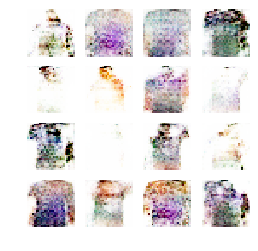

CPU times: user 6min 4s, sys: 1min 33s, total: 7min 38s
Wall time: 6min 52s


In [40]:
%%time
train(train_ds.take(100), EPOCHS)

### Restore the latest checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir))


### Create a gif animation 

In [ ]:
out_file = 'fmdcgan.gif'

with imageio.get_writer(out_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

    import IPython
    if IPython.version_info > (6,2,0,''):
        display.Image(filename=out_file)

![](fmdcgan.gif)